# K Means with Multiprocessing

In [1]:
#import libraries
import time
from tqdm import trange
import pandas as pd
import numpy as np
import random as rd
from itertools import repeat,chain
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
path = "/Users/rick/Desktop/Code_Dojo/GithubPortfolio/GitHubKMeans/"
data = pd.read_csv(path+'clustering.csv')
print(data.shape)
print(data.head())

(381, 13)
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001003   Male     Yes          1      Graduate            No   
1  LP001005   Male     Yes          0      Graduate           Yes   
2  LP001006   Male     Yes          0  Not Graduate            No   
3  LP001008   Male      No          0      Graduate            No   
4  LP001013   Male     Yes          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4583             1508.0       128.0             360.0   
1             3000                0.0        66.0             360.0   
2             2583             2358.0       120.0             360.0   
3             6000                0.0       141.0             360.0   
4             2333             1516.0        95.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Rural           N  
1             1.0         Urban           Y  
2         

## K Means 

In [3]:
def Euclidean_Dist(x,y):
    return np.sqrt(np.sum(np.power((x-y),2)))


def get_categories(X,K,Centroids,dist="Euclidean"):
    # Maintain copy of original data 
    X_clean = X
    
    # Select distance measure for clusters 
    dist_measures = {"Euclidean": Euclidean_Dist,}
    
    X_idx = list(range(X.shape[0]))
    X_idx.sort()
    
    # Calculate distance between every point in X_fit and Centroids and place in categories 
    samples_categories = []
    for i, index in enumerate(X_idx):
        dist_values = []
        for j,Centroid in enumerate(Centroids): 
            dist_values.append( [index,j, dist_measures[dist](Centroid,X_clean[index,:])]  ) 
        dists = [dist_values[k][2] for k,value in enumerate(dist_values)]   
        index_min = dists.index(min(dists))           
        samples_categories.append([index_min,index])      
        
    return samples_categories
    
    
def KMeans(X,K,itter=1,dist="Euclidean"):    
    X_np = X.values

    # Declare intial centroids
    Centroids_idx = np.random.choice(range(X.shape[0]), K, replace=False)
    Centroids = X_np[Centroids_idx,:]
    
    for a in range(itter):
        categories = get_categories(X_np,K,Centroids,dist="Euclidean")
        groups = []
        for i in range(K):
            values = []
            for l,value in enumerate(categories):
                if value[0] == i: values.append(value[1])
            if len(values) != 0:
                groups.append(X.iloc[ values,:])
            else: groups.append("group "+str(i)+ " is empty!")  

        new_centroids = []
        for i, group in enumerate(groups):
            group = group.values 
            new_centroids.append( np.mean(group,axis=0))    
            
        Centroids = new_centroids   
 
    return groups, np.array(Centroids)  

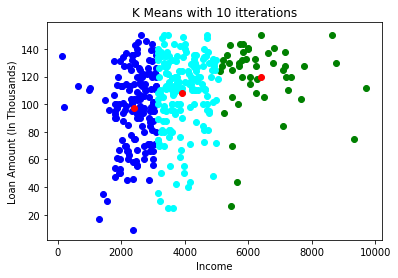

In [4]:
K=3  
n_itter = 10

X = data[["LoanAmount","ApplicantIncome"]]
X_train = X[["ApplicantIncome","LoanAmount"]] 

groups,Centroids = KMeans(X_train,K,n_itter)
    
color=['blue','green','cyan']
for i,group in enumerate(groups):
    if isinstance(group, str) == False:
         plt.scatter(group["ApplicantIncome"],group["LoanAmount"],c=color[i])
          
plt.scatter(Centroids[:,0],Centroids[:,1],c='red')
plt.title("K Means with {} itterations".format(n_itter))
plt.xlabel('Income')
plt.ylabel('Loan Amount (In Thousands)')
plt.show()

## Let's time it!

In [5]:
K=3  
X = data[["LoanAmount","ApplicantIncome"]]
X_train = X[["ApplicantIncome","LoanAmount"]] 

t0 = time.time()
KMeans(X_train,K,25)
t1 = time.time()

print("Time to run KMeans: ", t1-t0, "seconds")

Time to run KMeans:  0.359799861907959 seconds


## Now lets make this code fast!!!

### Multiprocessing

In [6]:
def Euclidean_Dist(x,y):
    return np.sqrt(np.sum(np.power((x-y),2)))


def get_distance_centroid(X_idx,X_clean,dist_measures,Centroids):
    samples_categories = []
    for i, index in enumerate(X_idx):
        dist_values = []
        for j,Centroid in enumerate(Centroids): 
            dist_values.append( [index,j, dist_measures(Centroid,X_clean[index,:])]  ) 
        dists = [dist_values[k][2] for k,value in enumerate(dist_values)]   
        index_min = dists.index(min(dists))           
        samples_categories.append([index_min,index])     
    return samples_categories


def mp_get_categories(X,K,itter=1,dist="Euclidean"):
    # Maintain copy of original data 
    X_clean = X
    
    # Select distance measure for clusters 
    dist_measures = {"Euclidean": Euclidean_Dist,}
    
    X_idx = list(range(X.shape[0]))
    X_idx.sort()
    
    X_fit_split = np.array_split(X_idx, min(mp.cpu_count(),K),axis=0)
    X_idx_split = np.array_split(np.array(X_idx), min(mp.cpu_count(),K),axis=0)

    # Calculate distance between every point in X_fit and Centroids and place in categories 
    pool = mp.Pool(min(mp.cpu_count(),K))
    samples_categories = pool.starmap(get_distance_centroid,zip(X_idx_split\
                                    ,repeat(X_clean),repeat(dist_measures[dist]),\
                                    repeat(Centroids)))
    samples_categories = list(chain(*samples_categories))
    return samples_categories

       
def MP_KMeans(X,K,itter=1,dist="Euclidean"):    
    X_np = X.values

    # Declare intial centroids
    Centroids_idx = np.random.choice(range(X.shape[0]), K, replace=False)
    Centroids = X_np[Centroids_idx,:]
    
    for a in range(itter):
        categories = mp_get_categories(X_np,K,Centroids,dist="Euclidean")
        groups = []
        for i in range(K):
            values = []
            for l,value in enumerate(categories):
                if value[0] == i: values.append(value[1])
            if len(values) != 0:
                groups.append(X.iloc[ values,:])
            else: groups.append("group "+str(i)+ " is empty!")  

        new_centroids = []
        for i, group in enumerate(groups):
            group = group.values 
            new_centroids.append( np.mean(group,axis=0))    
            
        Centroids = new_centroids   
 
    return groups, np.array(Centroids)  

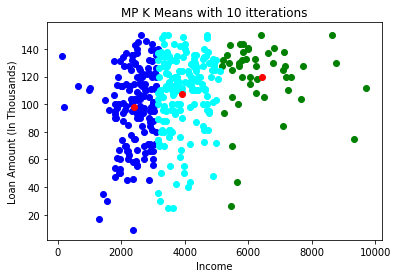

In [7]:
K=3  
n_itter = 10

X = data[["LoanAmount","ApplicantIncome"]]
X_train = X[["ApplicantIncome","LoanAmount"]] 

groups,Centroids = MP_KMeans(X_train,K,n_itter)
    
color=['blue','green','cyan']
for i,group in enumerate(groups):
    if isinstance(group, str) == False:
         plt.scatter(group["ApplicantIncome"],group["LoanAmount"],c=color[i])
          
plt.scatter(Centroids[:,0],Centroids[:,1],c='red')
plt.title("MP K Means with {} itterations".format(n_itter))
plt.xlabel('Income')
plt.ylabel('Loan Amount (In Thousands)')
plt.show()

## Let's time it!

In [8]:
K=3  
X = data[["LoanAmount","ApplicantIncome"]]
X_train = X[["ApplicantIncome","LoanAmount"]] 

t0 = time.time()
MP_KMeans(X_train,K,25)
t1 = time.time()

print("Time to run KMeans with multiprocessing: ", (t1-t0), "seconds")

Time to run KMeans with multiprocessing:  0.9267499446868896 seconds
